# Compute embeddings of splice sites

In [1]:
from embedding import model_selection
import os
import random
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import tqdm
from sklearn.decomposition import PCA

/opt/anaconda3/envs/torch201/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.chdir('/picb/rnasys2/zhouhanwen/nucTran/github/')

In [3]:
def find_splice_site(seq, ss):
    indexes = []
    index = -1
    while True:
        index = seq.find(ss, index + 1)
        if index == -1:
            break
        indexes.append(index)
    return indexes

## Process data

In [4]:
gene_ids = []
seqs = []
with open('SpliceSitePrediction/data/pre-mRNA_seqlenlt20k.fa') as f:
    for line in tqdm.tqdm(f):
        if line.startswith('>'):
            gene_ids.append(int(line.split('::')[0].split('>')[1]))
        else:
            seqs.append(line.strip())

15876it [00:00, 138353.05it/s]


In [5]:
np.random.seed(2024)
seq_df = pd.DataFrame({'gene_id': gene_ids, 'seq': seqs})
seq_df['seq_len'] = seq_df['seq'].apply(lambda x: len(x))
# Sample 1000 pre-mRNAs shorter than 14500 nucleotides
seq_df = seq_df[seq_df['seq_len'] < 14500].sample(1000)
seq_df.reset_index(inplace=True)

In [6]:
ss_df = pd.read_csv('SpliceSitePrediction/data/pre-mRNA_seqlenlt20k_ss.tsv', sep='\t')

In [7]:
model_state_path = 'pretrain/saving_model/mammalian80D_4096len1mer1sw_80M/checkpoint-250000/model.safetensors'
# model_state_path = None
model_max_length = 15000
device = torch.device("cuda:3")
tokenizer, model = model_selection(model_state_path, model_max_length)
model = model.to(device)

In [8]:
random.seed(2024)
donor_embedding_means = []
non_donor_embedding_means = []
acceptor_embedding_means = []
non_acceptor_embedding_means = []
model.eval()
with torch.no_grad():
    for i in tqdm.trange(len(seq_df)):
        seq = seq_df.loc[i, 'seq']
        gene_id = seq_df.loc[i, 'gene_id']
        donors = ss_df.loc[(ss_df['gene_id'] == gene_id) & (ss_df['type'] == 'donor'), 'relative_ss'].values.tolist()
        acceptors = ss_df.loc[(ss_df['gene_id'] == gene_id) & (ss_df['type'] == 'acceptor'), 'relative_ss'].values.tolist()
        gts = find_splice_site(seq, 'GT')
        non_donors = random.sample(list(set(gts) - set(donors)), len(donors))
        ags = find_splice_site(seq, 'AG')
        non_acceptors = random.sample(list(set(ags) - set(acceptors)), len(acceptors))

        inputs = tokenizer(seq, return_tensors="pt")
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        outputs = model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        outputs = outputs.last_hidden_state[0, 1 : -1, :]
        for ele in donors:
            # print(seq[ele-1:ele+1])
            embedding_mean = torch.mean(outputs[ele-1:ele+1, :], dim=0).tolist()
            donor_embedding_means.append(embedding_mean)
        for ele in non_donors:
            # print(seq[ele:ele+2])
            embedding_mean = torch.mean(outputs[ele:ele+2, :], dim=0).tolist()
            non_donor_embedding_means.append(embedding_mean)
        for ele in acceptors:
            # print(seq[ele-2:ele])
            embedding_mean = torch.mean(outputs[ele-2:ele, :], dim=0).tolist()
            acceptor_embedding_means.append(embedding_mean)
        for ele in non_acceptors:
            # print(seq[ele:ele+2])
            embedding_mean = torch.mean(outputs[ele:ele+2, :], dim=0).tolist()
            non_acceptor_embedding_means.append(embedding_mean)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:01<00:00,  1.28it/s]


In [9]:
gt_embedding_means = np.array(donor_embedding_means + non_donor_embedding_means)
gt_embedding_means.shape

(9464, 768)

In [10]:
ag_embedding_means = np.array(acceptor_embedding_means + non_acceptor_embedding_means)
ag_embedding_means.shape

(9464, 768)

In [11]:
np.save('embedding/data/SpliceSite/gt_embedding_mean_mammalian80D_4096len1mer1sw_80M_250k_1kpremrna.npy', gt_embedding_means)
# np.save('embedding/data/SpliceSite/gt_embedding_mean_no_pretrain_80M_1kpremrna.npy', gt_embedding_means)

In [12]:
np.save('embedding/data/SpliceSite/ag_embedding_mean_mammalian80D_4096len1mer1sw_80M_250k_1kpremrna.npy', ag_embedding_means)
# np.save('embedding/data/SpliceSite/ag_embedding_mean_no_pretrain_80M_1kpremrna.npy', ag_embedding_means)

## Compute NMI

In [13]:
labels = ['blue'] * len(acceptor_embedding_means) + ['green'] * len(acceptor_embedding_means)

In [14]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(gt_embedding_means)

In [15]:
normalized_mutual_info_score(labels, cluster_labels)

0.4912973250019226

In [16]:
label_df = pd.DataFrame({'predict_label': cluster_labels, 'true_label': labels})
pd.crosstab(label_df['true_label'], label_df['predict_label'])

predict_label,0,1
true_label,,
blue,3530,1202
green,93,4639


## tSNE

### donor

In [17]:
tsne = TSNE(n_components=2, verbose=2, random_state=2024)
tsne_array = tsne.fit_transform(gt_embedding_means)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9464 samples in 0.006s...
[t-SNE] Computed neighbors for 9464 samples in 0.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9464
[t-SNE] Computed conditional probabilities for sample 2000 / 9464
[t-SNE] Computed conditional probabilities for sample 3000 / 9464
[t-SNE] Computed conditional probabilities for sample 4000 / 9464
[t-SNE] Computed conditional probabilities for sample 5000 / 9464
[t-SNE] Computed conditional probabilities for sample 6000 / 9464
[t-SNE] Computed conditional probabilities for sample 7000 / 9464
[t-SNE] Computed conditional probabilities for sample 8000 / 9464
[t-SNE] Computed conditional probabilities for sample 9000 / 9464
[t-SNE] Computed conditional probabilities for sample 9464 / 9464
[t-SNE] Mean sigma: 2.873237
[t-SNE] Computed conditional probabilities in 0.505s
[t-SNE] Iteration 50: error = 86.9946365, gradient norm = 0.0111397 (50 iterations in 1.096s)
[t-SNE] Iteration 100: 

In [18]:
tsne_df = pd.DataFrame(tsne_array)
tsne_df['label'] = ['blue'] * len(acceptor_embedding_means) + ['green'] * len(acceptor_embedding_means)

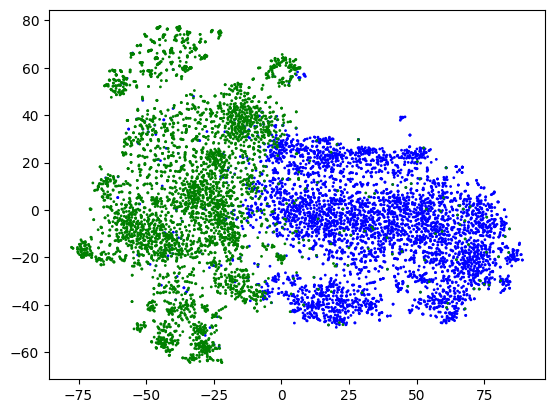

In [19]:
plt.scatter(tsne_df[0], tsne_df[1], c=tsne_df['label'], alpha=1, s=1)

In [20]:
tsne_df.columns = ['tsne1', 'tsne2', 'type']
tsne_df.loc[tsne_df['type'] == 'blue', 'type'] = 'donor'
tsne_df.loc[tsne_df['type'] == 'green', 'type'] = 'non_donor'
tsne_df.to_csv('embedding/data/SpliceSite/donor_embedding_mammalian80D_4096len1mer1sw_80M_250k_1kpremrna.tsv', sep='\t', index=False)

### acceptor

In [21]:
tsne = TSNE(n_components=2, verbose=2, random_state=2024)
tsne_array = tsne.fit_transform(ag_embedding_means)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9464 samples in 0.006s...
[t-SNE] Computed neighbors for 9464 samples in 0.732s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9464
[t-SNE] Computed conditional probabilities for sample 2000 / 9464
[t-SNE] Computed conditional probabilities for sample 3000 / 9464
[t-SNE] Computed conditional probabilities for sample 4000 / 9464
[t-SNE] Computed conditional probabilities for sample 5000 / 9464
[t-SNE] Computed conditional probabilities for sample 6000 / 9464
[t-SNE] Computed conditional probabilities for sample 7000 / 9464
[t-SNE] Computed conditional probabilities for sample 8000 / 9464
[t-SNE] Computed conditional probabilities for sample 9000 / 9464
[t-SNE] Computed conditional probabilities for sample 9464 / 9464
[t-SNE] Mean sigma: 3.001399
[t-SNE] Computed conditional probabilities in 0.510s
[t-SNE] Iteration 50: error = 87.6844559, gradient norm = 0.0112472 (50 iterations in 1.036s)
[t-SNE] Iteration 100: 

In [22]:
tsne_df = pd.DataFrame(tsne_array)
tsne_df['label'] = ['blue'] * len(acceptor_embedding_means) + ['green'] * len(acceptor_embedding_means)

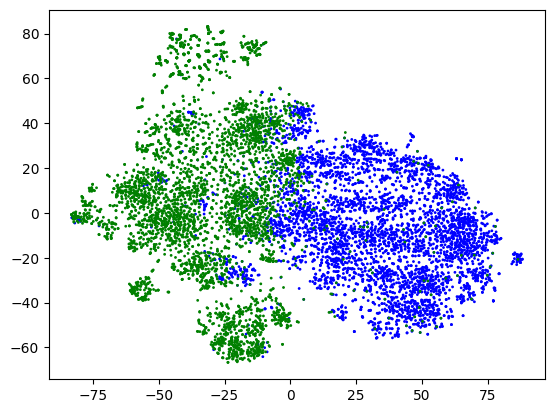

In [23]:
plt.scatter(tsne_df[0], tsne_df[1], c=tsne_df['label'], alpha=1, s=1)

In [24]:
tsne_df.columns = ['tsne1', 'tsne2', 'type']
tsne_df.loc[tsne_df['type'] == 'blue', 'type'] = 'acceptor'
tsne_df.loc[tsne_df['type'] == 'green', 'type'] = 'non_acceptor'
tsne_df.to_csv('embedding/data/SpliceSite/acceptor_embedding_mammalian80D_4096len1mer1sw_80M_250k_1kpremrna.tsv', sep='\t', index=False)